# TA Review 1
*1/16/2024*

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Jordan Sacks
* jordansacks@uchicago.edu

### Agenda
**Homework 1 Topics**
- Mapping Cashflows
- Solving for YTM
- Bootstrapping vs OLS vs Nelson-Siegel <br>

**Homework 2 Topics**
- Discount Curve
- Duration Calculation
- Convexity Calculation
- Hedge Ratios
- Level, Slope, Curvature Factors
- PCA to Get Level, Slope, Curvature

### Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

### Data

In [2]:
# Set params and import rawdata
QUOTE_DATE = '2023-07-26'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

# Ensure data is all from the same quote date
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'
display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2023-07-26.'

# Mapping Cashflows
Important things to keep note:
- Is the data cleaned?
 - Restrict Yield: Ensure that yields are positive. There may be bad datapoints or illiquid securities with wide bid-asks that we do not want to model off of
 - Restrict TIPS: Cannot mix bonds and TIPS since TIPS use a different formula so by default, keep this true to remove them
 - Restrict Dates Maturing: Adjust data based on a minimum or maximum maturity date
 - Restrict Redundant: This is helpful if we want to ensure 1 security per cashflow date
- Will it help to have cashflows defined for equal interval maturity dates (e.g., every 6 months)? This can help when handling forwards, swaps, etc.


#### Clean Data

In [3]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, 
                         t_date=t_current, 
                         filter_yld = RESTRICT_YLD, 
                         filter_tips = RESTRICT_TIPS, 
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)

In [4]:
data.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,20230727.400000,2023-07-26,99.986097,99.986125,99.986111,M,I,0.000000,0.000139,0.000139,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207231,20230731.202750,2023-07-26,99.984375,100.015625,100.000000,M,I,1.337017,0.000306,0.000075,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
207742,20230731.200120,2023-07-26,99.937500,99.976562,99.957031,M,I,0.060773,0.000238,0.000089,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
206998,20230731.201250,2023-07-26,99.937500,99.976562,99.957031,M,I,0.607735,0.000112,0.000120,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
208025,20230801.400000,2023-07-26,99.914917,99.915083,99.915000,M,I,0.000000,0.000135,0.000142,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN


#### Calculate cashflows
The ***treasury_cmds.py*** file is very helpful! The calc_cashflows function essentially does the following steps:
1. For each security, get the coupon dates
2. Apply the coupon rate at each coupon date that is applicable. Note that this function assumes semiannual rates
3. Apply the principle amount of 100 at the maturity date

In [5]:
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

c:\Users\josel\Documents\GitHub\finm-fixedincome-2024\reviews\../cmds\treasury_cmds.py:61: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
c:\Users\josel\Documents\GitHub\finm-fixedincome-2024\reviews\../cmds\treasury_cmds.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
c:\Users\josel\Documents\GitHub\finm-fixedincome-2024\reviews\../cmds\treasury_cmds.py:61: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future

In [6]:
CF.head()

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
207231,0,101.3750,0,0,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
207742,0,100.0625,0,0,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
206998,0,100.6250,0,0,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
208025,0,0.0000,100,0,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


#### Adjust to have monthly cashflows

In [7]:
CF_monthly = CF.resample('m',axis=1).sum()
CF_monthly.drop(columns=CF_monthly.columns[(CF_monthly==0).all()],inplace=True)
CF_monthly = CF_monthly.fillna(0).sort_index(axis=1)
CF_monthly

C:\Users\josel\AppData\Local\Temp\ipykernel_4616\2261640705.py:1: FutureWarning: DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.
  CF_monthly = CF.resample('m',axis=1).sum()
C:\Users\josel\AppData\Local\Temp\ipykernel_4616\2261640705.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  CF_monthly = CF.resample('m',axis=1).sum()


,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,...,2051-09-30,2051-11-30,2052-02-29,2052-03-31,2052-05-31,2052-08-31,2052-09-30,2052-11-30,2053-02-28,2053-03-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
207231,101.3750,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
207742,100.0625,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
206998,100.6250,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
208025,0.0000,100.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0.0000,0.0000,0.0000,0.0,1.4375,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0.0,0.0000,0.0000
207934,0.0000,1.5000,0.0000,0.0,0.0000,0.0,0.0,1.5000,0.0000,0.0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0.0,0.0000,0.0000
207977,0.0000,0.0000,0.0000,0.0,2.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102.0,0.0000,0.0000


# Solving for YTM
Let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.
- Time to Maturity = T-t
- Assume par value of 100

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:

- This formula is a sum of the cashflows. The first part of the formula is the sum of the coupons. The 2nd part of the formula (outside of the summation) is adding back the face value. Note this also includes the last coupon payment as part of the par value paid back at maturity. 
- This equation assumes a semiannual coupon payment given the $\frac{c}{2}$ in the numerator. This can be explicitly changed to match whatever frequency is required.
- What does the YTM mean in this equation? Its the discount factor for each cashflow. This is because of the time-value of money. Therefore, this equation identifies the discount factor across all cashflows to arrive at any given bond's price. 

$\begin{align}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align}
$

To solve for YTM, we must use a non-linear solver, such as fsolve from scipy. Using the above data, here are the following steps:
 

#### 1.  Calculate dirty price (include the coupon interest accrual)

In [8]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]

#### 2. Get Maturity Grid (The time difference between the maturity of the cashflows and the date of the quoted data divided by 365.25)

In [9]:
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)
maturity_grid

2023-07-27     0.002738
2023-07-31     0.013689
2023-08-01     0.016427
2023-08-03     0.021903
2023-08-08     0.035592
                ...    
2052-08-15    29.056810
2052-09-15    29.141684
2052-11-15    29.308693
2053-02-15    29.560575
2053-03-15    29.637235
Length: 366, dtype: float64

#### 3. Use fsolve to solve for YTM for each issue
fsolve Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html

$$ PV = \frac{CF}{(1+\frac{r}{n})^{n\cdot(T-t)}}$$

In [10]:
def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [11]:
# Create an object to store all the ytm's. Remeber that each bond has a unique YTM!
ytm = pd.Series(index=px.index,dtype=float)
# For each bond, create a functon that is equal to the current price less the present value.
# The optimization then identifies the variable, YTM, that makes the function equal 0
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

In [12]:
ytm

KYTREASNO
207997    0.051382
207231    0.027564
207742    0.032905
206998    0.044223
208025    0.052441
            ...   
207891    0.039519
207934    0.039492
207977    0.039301
208019    0.039460
208062    0.039738
Length: 386, dtype: float64

### Additional Notes on YTM
- YTM has a nonlinear and inverse relationship with price. The compounding of the cashflows is the reason for the nonlinear relationship. As the time to maturity increases, the nonlinearity increases as could be seen in the lecture notes comparing 1 vs 10 vs 30 year zero-coupon bonds
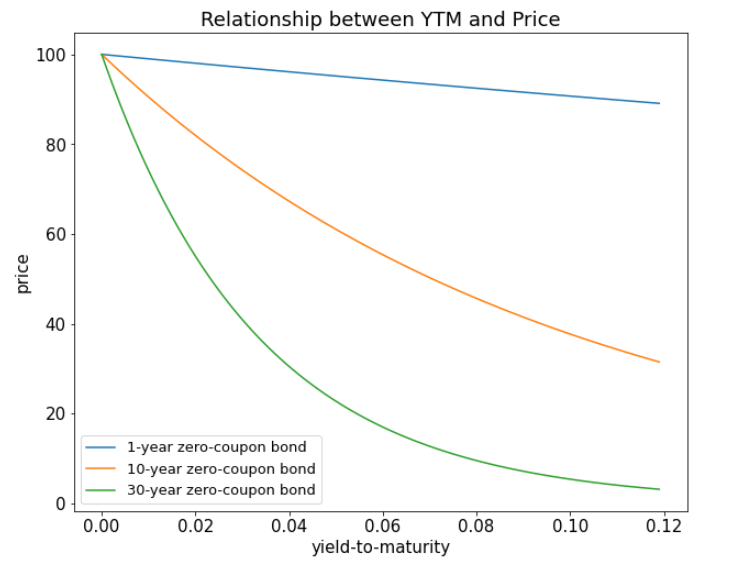
- YTM helps compare bonds against other bonds by showing the annual average return IF you can reinvest the coupons and you hold till maturity. 
- YTM is NOT the return because of the stylized assumptions noted above. Its the discount rate that would rationalize the bond. 


# YTM vs Spot Rates

- The spot rate does not depend on the specific bond like YTM does. It is a function of the cashflow timing and thus can be applied to any bond. 
- Within the formula, youll notice that the rate used is different for each time period
$$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{r(t,T_i)}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{r(t,T)}{2}\right)^{2(T-t)}}
\end{align*}
$$

# Discount Curve
**The discount rates are uniquely determined and can be converted to a spot curve of any compounding frequency.**

Denote the discount curve as $Z(t,T)$.

* This value depends on the maturity. It represents the present value of the cashflows
* It is not compounded. Any compounded spot rate will lead to this discount. 

The discount curve is useful for multiplicative pricing.

### Zero Coupon Bond

$
\begin{align}
P_j(t,T) = Z(t,T) \times 100
\end{align}
$

### Coupon Bond

$\begin{align}
\displaystyle P_j(t,T,c) = \sum_{i=1}^{n-1} 100 Z(t,T_i)\frac{c}{2} + 100 Z(t,T)\left(1+\frac{c}{2}\right)
\end{align}
$


#### Use
If we estimate the discount curve (equivalent to estimating the spot curve,) then we can apply these discount factors to price other fixed-income securities.

#### Assumptions
- Flat term structure equal to the rate

In [13]:
RATE = .02

#### 1. Calculate the Discount Factors
$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$

In [14]:
discount_factors = np.exp(-RATE * maturity_grid)

#### Plot

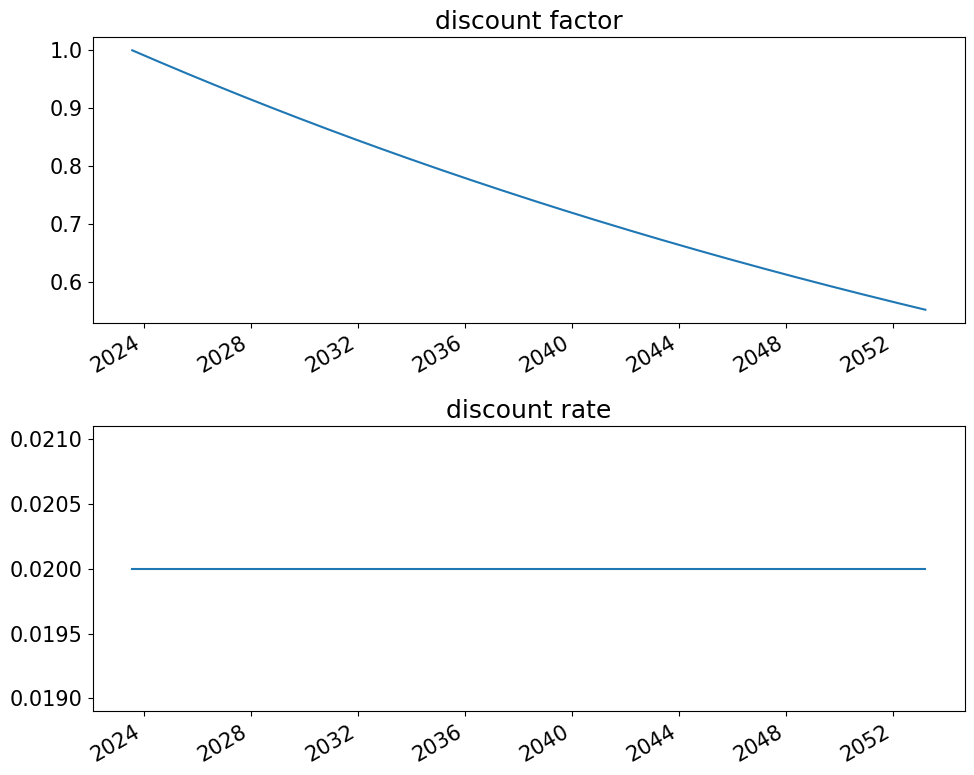

In [15]:
curves = pd.DataFrame(discount_factors,index=CF.columns, columns=['discount factor'])
curves['discount rate'] = RATE

fig,ax = plt.subplots(2,1,figsize=(10,8))
curves['discount factor'].plot(ax=ax[0],title='discount factor');
curves['discount rate'].plot(ax=ax[1],title = 'discount rate');
plt.tight_layout()

As discussed in lecture, the discount factors are now a series based on the maturity date. In other words, the present value of a cashflow at any given date in the future can be determined from the first plot. The discount rate, by our definition, was set equal to 2% 

# Bootstrapping vs OLS vs Nelson-Siegel

**Bootstrapping** <br>
If $n=k$, 
* perfectly identified system of equations
* no need for error, $\epsilon$
* **solve** with linear system of equations
* This usually requires curating the data (i.e., removing issues that seem wrong or less accurate so youre left with a subset)
* Common issues include **Biased Data and not having a perfectly identified system to run on**

**OLS** <br>
If $n>k$,
* overidentified
* include $\epsilon$. This can be observation error (i.e., the price changes 1 second after initially reading the price) or liquidity impacts
* **estimate** with regression
* Do not need an intercept
* Common issues include **Multicollinearity & overfitting**

With respect to **Multicollinearity**:
* Having multiple treasuries with cashflows on dates without any treasury maturing means that it is impossible to identify the relative value of these coupons. Specifically, this cashflow matrix means the system of linear equations is undetermined. The discounts at the dates without maturities are unidentified by this system. Therefore expect that Boostrapping and OLS may struggle with estimation when this is the case!

**Nelson-Siegel** <br>
* Missing data
* Overfitting in-sample
* Allows all the data to be used to estimate the parameters of the model. This therefore improves the statistical power of the model because of all the data
* Common issues are the **biases introduced by the data if the true model is not represented by the data**. 

# Duration
**Duration** refers to the sensitivity of a bond (or other fixed-income product) to the **level of interest rates**.

Rather than measure sensitivity to the 3-month, 1-year, or 10-year rate, measure sensitivity to a parallel shift in all these rates, all else equal.

The standard definition reviews a parallel shift in all rates because rates along the curve are highly correlated. 

### Price approximation

If we know the duration of a fixed income asset, then we can approximate the percentage price change in response to a shift in rates. The approximation is

$\begin{align}
\frac{dP}{P} \approx -D\times dr
\end{align}$


### Duration of a zero-coupon bond

For a **zero coupon bond** this derivative has a simple solution:
$$\begin{align}
D_{\text{zero}} \equiv -\frac{1}{P(t,T,0)}\frac{dP(t,T,0)}{dr} = T-t
\end{align}$$

### Duration of a coupon bond
$$\begin{align}
D_{\text{coupon bond}} =& \sum_{i=1}^n w_i T_i
\end{align}$$

* As the coupon increases, the duration decreases. This is because more of the total cashflow is coming earlier in the life of the bond
* As the coupon rate approaches 0, the duration approaches the time to maturity
* If we duration as a measure of the sensitivity of a bond to a spot rate curve shock, then the front end of the curve is rather good at approximating the change but the back-end of the curve will be an overestimation. 
#### For small shifts in the yield curve, duration gives a close approximation.
#### For large shifts in the spot curve, we need something better.

#### 1. Calculate the weights (assume coupon bonds and you have the spot curve available)
This essentially means to discount the cashflows to present day and identify the percentage each cash flow is of the total cash flows of the bond

In [16]:
wts = CF.mul(curves['discount factor'],axis=1)
wts = wts.div(wts.sum(axis=1),axis=0)
wts.tail()

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207891,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.006835,0.000000,0.000000,0.477517,0.000000,0.000000,0.000000,0.000000,0.000000
207934,0.0,0.0,0.0,0.0,0.0,0.0,0.012178,0.0,0.0,0.0,...,0.000000,0.000000,0.006887,0.000000,0.000000,0.461376,0.000000,0.000000,0.000000,0.000000
207977,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.007848,0.000000,0.000000,0.007770,0.000000,0.000000,0.392301,0.000000,0.000000
208019,0.0,0.0,0.0,0.0,0.0,0.0,0.013171,0.0,0.0,0.0,...,0.000000,0.000000,0.007448,0.000000,0.000000,0.007374,0.000000,0.000000,0.410081,0.000000
208062,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.007523,0.000000,0.000000,0.007448,0.000000,0.000000,0.007374,0.000000,0.000000,0.410103


#### 2. Multiply the weights by the maturity and sum for all cash flow components

In [17]:
duration = (wts @ maturity_grid.to_frame()).rename(columns={0:'duration'})
duration.tail()

,duration
KYTREASNO,
207891,20.526098
207934,20.361988
207977,19.496590
208019,19.859591
208062,19.939300


# Convexity
Duration approximates the bond's price change with a linear approximation, (the first derivative.)

This approximation is good for small changes in the rate, but it is inadequate for larger changes.

Accordingly, we may find a second-order approximation beneficial.

This second-order term is known as the **convexity** of the bond.

## Price approximation

$\begin{align}
\frac{dP}{P} \approx -D\times dr + \frac{1}{2}C\times (dr)^2
\end{align}$

where $C$ denotes the convexity of the bond,

$\begin{align}
C \equiv & \frac{1}{P}\frac{d^2P}{dr^2}
\end{align}$


## Zero coupon bond

For a zero-coupon bond, one can show that the convexity is

$\begin{align}
C =& \frac{1}{P(t,T,0)}\frac{d^2P(t,T,0)}{dr^2}\\
=& (T-t)^2
\end{align}$


## Coupon bonds

Again, we rely on the result that a coupon bond may be decomposed as a portfolio of zero-coupon bonds (STRIPS).

For a portfolio with weights $w_i$ in securities each with convexity, $C_i$, we have,

$\begin{align}
C = \sum_{i=1}^n w_iC_i
\end{align}$

Then for a coupon bond with cashflows at times $T_i$, we once again decompose it as follows,

$\begin{align}
C =& \sum_{i=1}^n w_i(T_i-t)^2\\
\end{align}$

where these are the same weights used for the coupon bond duration calculation.

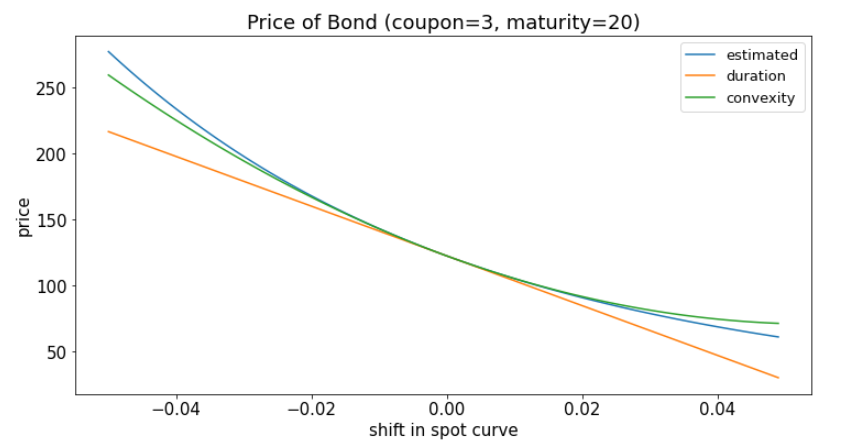

#### 1. Calculate Weights (same weights calculated in the duration calculation)

#### 2. Calculate using the formula for coupon bonds

In [18]:
duration['convexity'] = wts @ maturity_grid**2

duration.tail()

,duration,convexity
KYTREASNO,,
207891,20.526098,518.747910
207934,20.361988,516.479165
207977,19.496590,484.138131
208019,19.859591,501.858022
208062,19.939300,504.993130


# Hedge Ratios
Suppose you are building a trade to go long $n_i$ bonds and short $n_j$ notes.

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$


#### Get Price and Duration
- For the price, you can choose the bid/ask or calculate a midprice. <br>
- For the duration, this is in the data under the column: ***TDDURATN*** 

#### Create Dataframe that Tracks Positions
$$ LongPosition = \frac{Size}{Price}$$

#### Calculate Hedge Ratio using Dollar Duration
$$ \frac{D_{\$,i}}{D_{\$,j}} = \frac{Duration_{i}}{Duration_{j}} \cdot \frac{Price_{i}}{Price_{j}}$$

#### Create hedged position

$$ ShortPosition = -HedgeRatio \cdot LongPosition$$

# Level, Slope, Curvature
$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

In [19]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)
yields.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


In [20]:
shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index>DATETHRESH]

In [21]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.381529,-0.176025
slope,-0.381529,1.000000,0.642917
curvature,-0.176025,0.642917,1.000000


# PCA
PCA gives linear combinations of interest rates along the curve which have maximum explanatory power in its variation.

The factors are orthogonal to each other.

They explain decreasing amounts of variance.
* Given the high correlation across these rates, PCA can explain most the total variation with a single factor.


In [22]:
pca = PCA(svd_solver='full', n_components = 3)
pca.fit(yields)

pca_factors = pd.DataFrame(pca.transform(yields), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=yields.index)
pca_factors.head()

,pca.f1,pca.f2,pca.f3
caldt,,,
1961-06-14,-4.965352,-0.696269,-0.302070
1961-06-15,-4.903186,-0.679494,-0.344504
1961-06-16,-4.896366,-0.674092,-0.348131
1961-06-19,-4.861600,-0.661547,-0.373938
1961-06-20,-4.871809,-0.656403,-0.334086


### Loadings

In [23]:
maturities = pd.DataFrame({'maturities':[i for i in yields.columns]})
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings = pca_loadings.transpose()
pca_loadings.columns = ['pca.l{}'.format(i+1) for i in range(pca.n_components_)]
pca_loadings = maturities.join(pca_loadings)
pca_loadings

,maturities,pca.l1,pca.l2,pca.l3
0,1,0.411927,-0.588222,0.458276
1,2,0.411300,-0.399075,0.009748
2,5,0.392732,-0.048761,-0.391938
3,7,0.378209,0.085207,-0.448776
4,10,0.363191,0.201137,-0.365339
5,20,0.343874,0.441211,0.359914
6,30,0.337209,0.499974,0.414564


<Axes: >

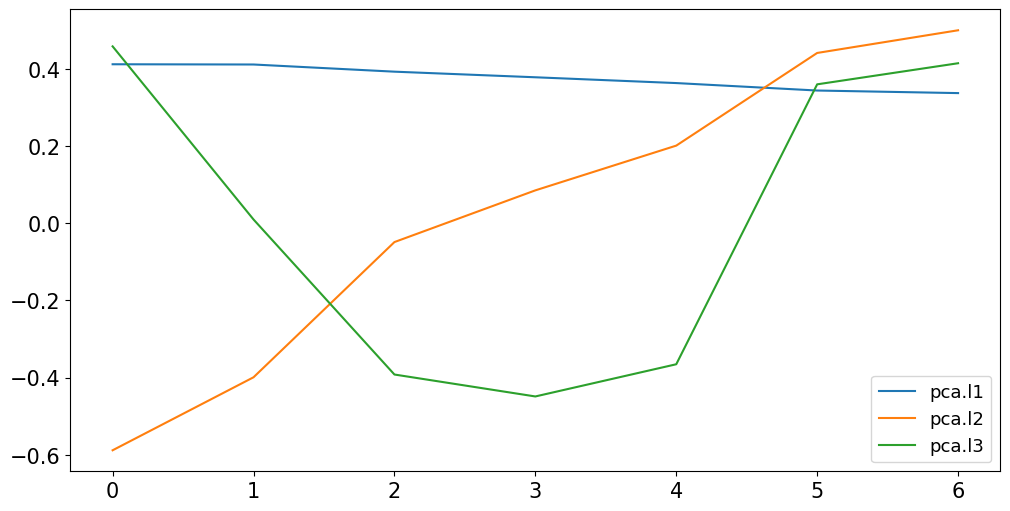

In [24]:
pca_loadings[['pca.l1', 'pca.l2', 'pca.l3']].plot()

### Correlation of PCA Factors
By definition, they are orthongonal

In [25]:
pca_factors.corr()

,pca.f1,pca.f2,pca.f3
pca.f1,1.000000e+00,-1.020747e-15,6.544983e-15
pca.f2,-1.020747e-15,1.000000e+00,-7.766225e-16
pca.f3,6.544983e-15,-7.766225e-16,1.000000e+00


### Predicting Rates Using PCA Model

In [26]:
model = pd.DataFrame(index = yields.index)
for i in range(len(yields.columns)):
    model[yields.columns[i]] = pca_factors.apply(lambda x:
                                                 (x*pca_loadings.iloc[i,1:].values).sum() + yields.mean().to_list()[i],
                                                 axis=1)


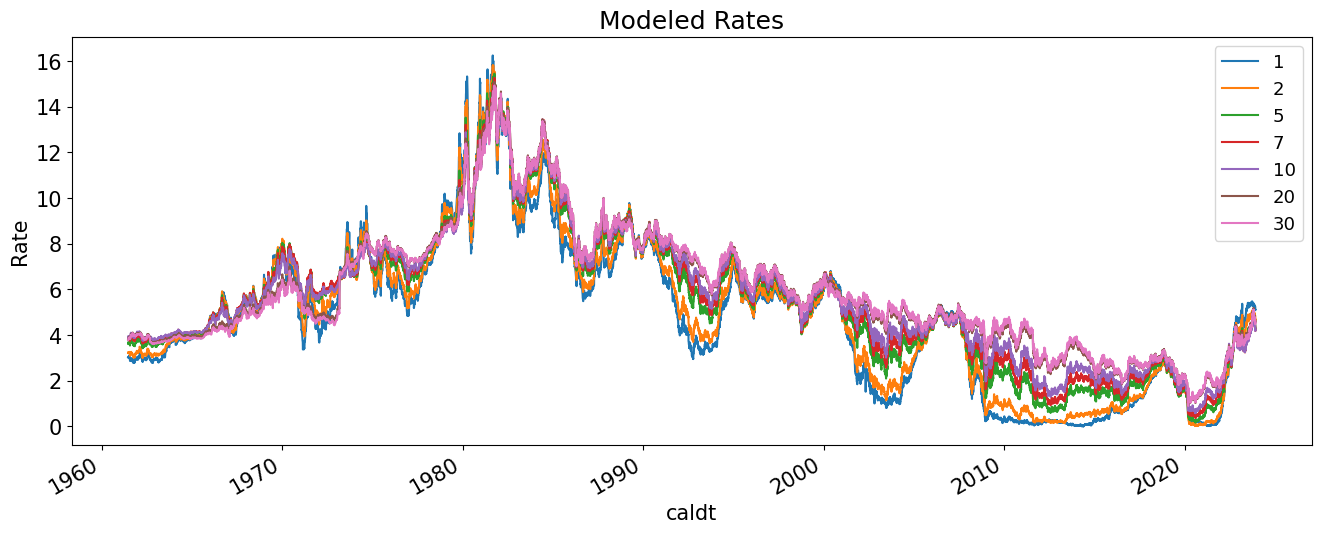

In [27]:
model.plot(figsize=(16, 6))
plt.title("Modeled Rates")
plt.ylabel("Rate")
plt.show();

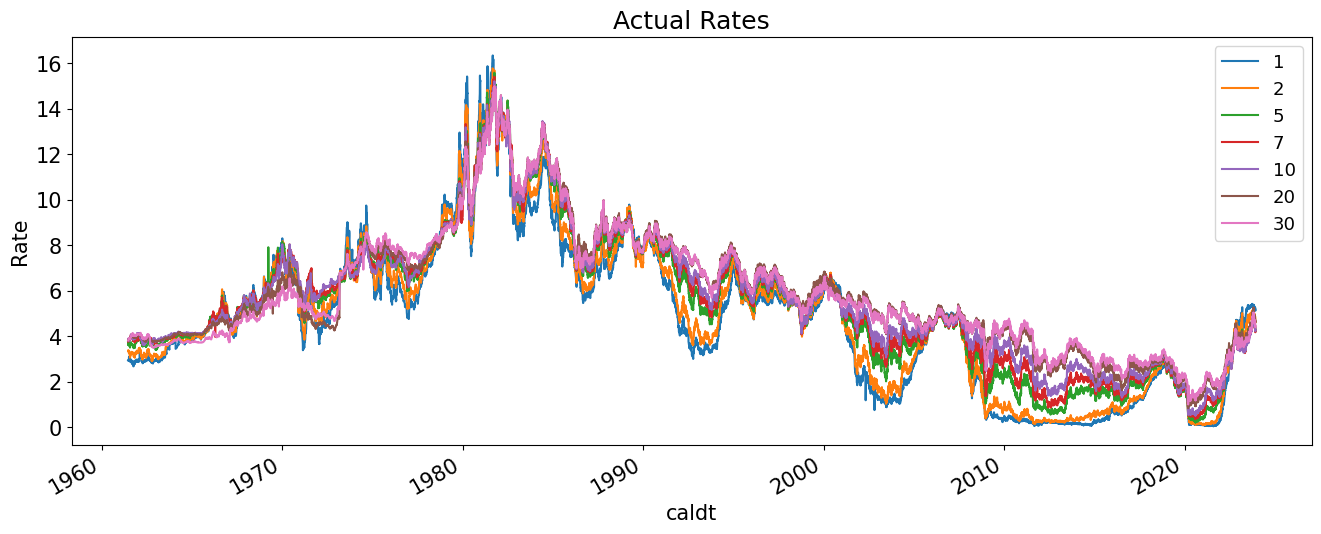

In [28]:
yields.plot(figsize=(16, 6))
plt.title("Actual Rates")
plt.ylabel("Rate")
plt.show();

***